In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import csv
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
dftrain = pd.read_csv("/kaggle/input/math482-2024-2025-1-hw-01/train.csv")
dftrain.head()
target= dftrain["yield"]
dftrain.drop(["yield","id"], inplace=True, axis=1)
dftest=pd.read_csv("/kaggle/input/math482-2024-2025-1-hw-01/test.csv")
ids=dftest["id"]
dftest.drop(["id"], inplace=True, axis=1)
dftrain.isna().sum()
dftrain.describe()

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/math482-2024-2025-1-hw-01/train.csv'

In [67]:
from sklearn import preprocessing
columns=dftrain.columns
min_max_scaler = preprocessing.MinMaxScaler()
dftrain=min_max_scaler.fit_transform(dftrain)
dftest=min_max_scaler.fit_transform(np.array(dftest))
trainY=np.array(target)

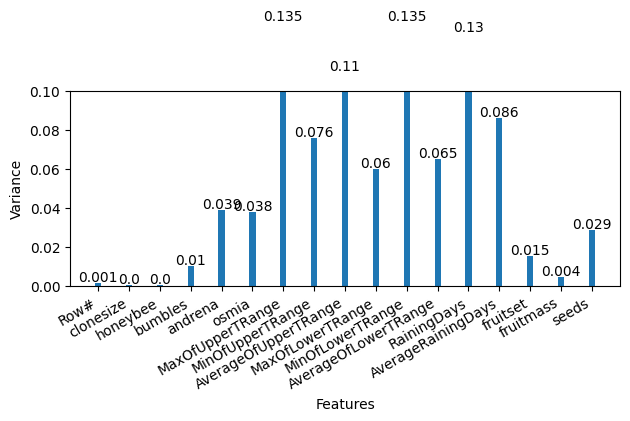

In [68]:
fig, ax = plt.subplots()
x=columns
y=dftrain.var(axis=0)
ax.bar(x, y, width=0.2)
ax.set_xlabel('Features')
ax.set_ylabel('Variance')
ax.set_ylim(0, 0.1)

for index, value in enumerate(y):
    plt.text(x=index, y=value+0.001, s=str(round(value, 3)), ha='center')
    
fig.autofmt_xdate()
plt.tight_layout()

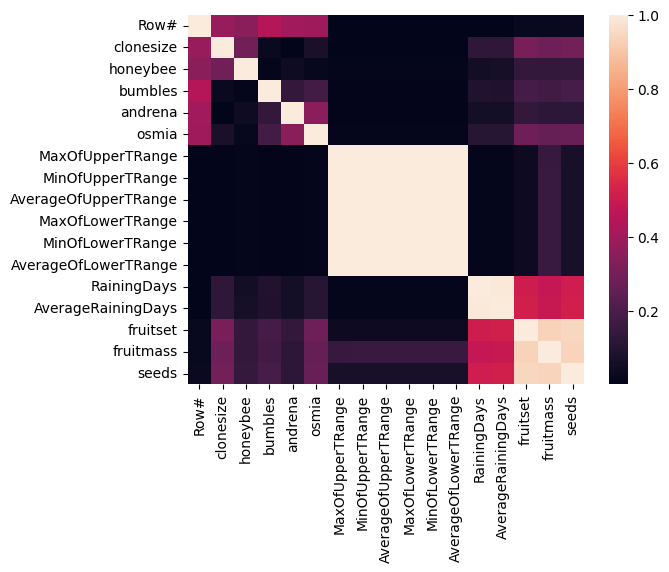

In [69]:
import seaborn as sns
dftrain=pd.DataFrame(dftrain, columns=columns)
dftest=pd.DataFrame(dftest, columns=columns)
sns.heatmap(dftrain.corr().abs())
plt.show()

In [70]:
from sklearn.ensemble import  GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression
import xgboost as xgb
from xgboost import XGBRegressor

In [71]:
trainX=np.array(dftrain)
mutual_info=mutual_info_regression(trainX,target)
mutual_info=pd.Series(mutual_info)
mutual_info.index=dftrain.columns
mutual_info.sort_values(ascending=False)

fruitset                1.676101
seeds                   1.317407
fruitmass               1.163455
AverageRainingDays      0.207437
RainingDays             0.207019
Row#                    0.177526
clonesize               0.109112
osmia                   0.066710
honeybee                0.049484
andrena                 0.044787
bumbles                 0.024816
MaxOfUpperTRange        0.000000
MinOfUpperTRange        0.000000
MaxOfLowerTRange        0.000000
MinOfLowerTRange        0.000000
AverageOfLowerTRange    0.000000
AverageOfUpperTRange    0.000000
dtype: float64

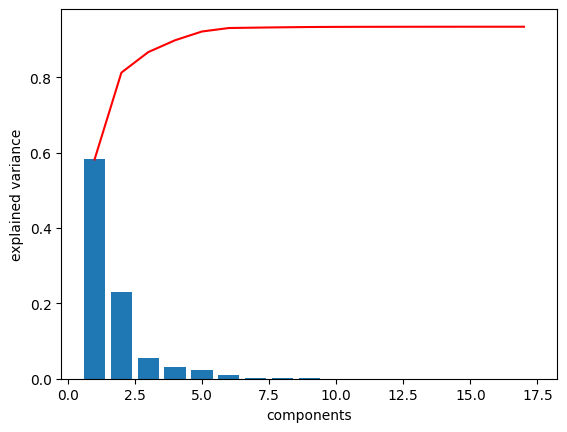

In [72]:
from sklearn.decomposition import PCA
pca1=PCA()
xpac1=pca1.fit_transform(np.array(dftrain))
plt.bar(range(1,len(pca1.explained_variance_)+1),pca1.explained_variance_)
plt.ylabel("explained variance")
plt.xlabel("components")
plt.plot(range(1,len(pca1.explained_variance_)+1), np.cumsum(pca1.explained_variance_),c="red")

In [73]:
dftrain.drop(["clonesize","honeybee","Row#","MinOfUpperTRange","MaxOfUpperTRange","MinOfLowerTRange","AverageOfUpperTRange"], inplace=True, axis=1)
dftest.drop(["clonesize","honeybee","Row#","MinOfUpperTRange","MaxOfUpperTRange","MinOfLowerTRange","AverageOfUpperTRange","AverageOfLowerTRa"], inplace=True, axis=1)

In [74]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(dftrain,target,test_size=0.3)

In [75]:
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [53]:
model=tf.keras.Sequential([
    layers.InputLayer(shape=(11,)),
    layers.Dense(units=64, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(units=32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(units=32, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(units=16, activation="relu"),
    layers.BatchNormalization(),
    layers.Dense(units=1)
])
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.005), loss='mean_absolute_error')

In [3]:
history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,
    verbose=1, epochs=1000)

NameError: name 'model' is not defined

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [77]:
model=XGBRegressor()
model.fit(X_train_pca,target) 

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

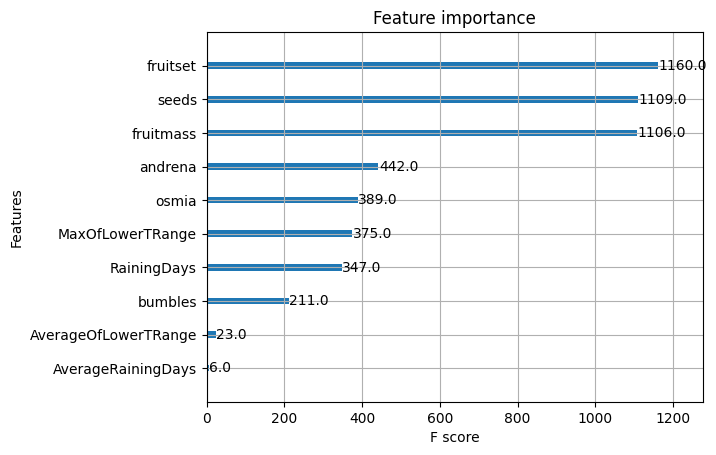

In [78]:
xgb.plot_importance(model,plt.gca())

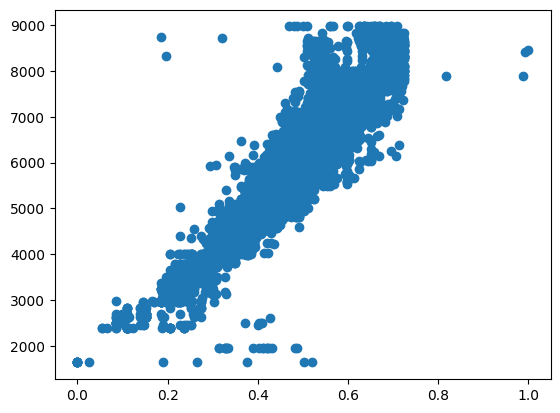

In [79]:
plt.scatter(dftrain["fruitset"],target)

In [80]:
plt.scatter(dftrain["AverageOfUpperTRange"],target)

KeyError: 'AverageOfUpperTRange'

In [81]:
model.score(X_test,y_test)

0.957534890655185

In [83]:
results=model.predict(dftest)

In [85]:
finalarr=[]
results=model.predict(X_test).flatten()
for i in range(len(results)):
    finalarr.append([15000+i,results[i]])
writer = csv.writer(open("/kaggle/working/submission.csv", 'w'))
for row in finalarr:
    writer.writerow(row)
